# Normales de precipitación a escala de cuenca nivel 2 

## Dirección Nacional de Aguas (DINAGUA)

#### Jose Valles (jose.valles.leon@gmail.com)

## Importar modulos y definir funciones

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
import numpy as np
import calendar

sns.set()

from IPython.display import HTML

Se importa la serie de precipitacón diaria a nivel de cuenca 2 (Dinagua) obtenido de ejecutar Delft-FEWS (FEWS-UY)

In [26]:
PRECIP_DIARIA = pd.read_csv(r'input/daily_rainfall_codcuenca2.csv',sep=",")
PRECIP_DIARIA['FECHA'] = pd.to_datetime(PRECIP_DIARIA['FECHA'])

## Normales de precipitación para cuencas hidrográficas nivel 2

Seleccionar el periodo de referencia 1991-2020

In [27]:
PRECIP_DIARIA_SELECCION = PRECIP_DIARIA[(PRECIP_DIARIA['FECHA'] > '1991-01-01') & (PRECIP_DIARIA['FECHA'] <= '2021-01-01')]

Mostrar los ultmos valores seleccionados

In [28]:
HTML(PRECIP_DIARIA_SELECCION.tail(5).to_html(index=False))

FECHA,63,67,28,52,45,42,40,31,33,32,30,12,13,44,10,15,27,29,24,22,26,20,58,55,54,57,50,43,17,23,65,21,61,64,68,66,62,60,53,51,41,14,11,16,19,18,56
2020-12-27 07:00:00,0.4,0.0,0.2,0.0,0.5,0.0,0.0,1.1,0.7,0.0,0.4,0.0,0.0,2.7,0.0,0.0,0.0,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.8,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-28 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.7,0.0,3.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0
2020-12-29 07:00:00,7.4,0.0,0.0,0.0,0.4,0.0,0.0,0.2,0.6,0.1,0.0,0.0,0.0,0.2,0.8,0.0,2.0,0.0,0.0,0.0,0.3,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.1,10.8,2.5,0.0,1.5,10.9,3.5,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,1.8
2020-12-30 07:00:00,1.3,3.0,14.5,30.5,4.9,4.6,3.4,21.5,6.1,6.1,19.4,14.3,16.3,6.7,10.9,22.1,4.3,7.7,2.1,10.3,2.5,4.7,7.0,6.9,8.0,8.2,10.2,7.2,12.6,5.9,6.3,7.0,6.9,2.5,3.0,3.1,3.7,11.8,12.7,24.6,2.4,28.0,6.4,15.2,7.7,5.0,10.7
2020-12-31 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Se acumula la precipitación diaria a una escala mensual para cada cuenca hidrográfica de nivel 2

In [29]:
# Definir la fecha como indice
PRECIP_DIARIA_SELECCION = PRECIP_DIARIA_SELECCION.set_index('FECHA')
# Agregar precipitación diaria a mensual. Si en un mes se tiene mas de 5 valores faltantes, entonces no se calcula la precipitación memsual
PRECIP_MENSUAL = PRECIP_DIARIA_SELECCION.resample('M').apply(lambda x: x.sum() if x.isnull().sum() < 5 else np.nan)
# Crear nuevas columnas de año y mes 
PRECIP_MENSUAL['Year'] = PRECIP_MENSUAL.index.year
PRECIP_MENSUAL['Month'] = PRECIP_MENSUAL.index.month
PRECIP_MENSUAL['Month'] = PRECIP_MENSUAL['Month'].apply(lambda x: calendar.month_abbr[x])

Mostrar resultados de la agregación temporal

In [30]:
HTML(PRECIP_MENSUAL.head(2).to_html())

,63,67,28,52,45,42,40,31,33,32,30,12,13,44,10,15,27,29,24,22,26,20,58,55,54,57,50,43,17,23,65,21,61,64,68,66,62,60,53,51,41,14,11,16,19,18,56,Year,Month
FECHA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1991-01-31,99.2,80.1,85.9,110.0,55.2,37.1,37.9,87.8,52.7,79.1,92.7,92.9,125.0,79.7,78.6,224.1,69.5,77.4,136.8,132.9,78.1,132.1,163.4,177.6,100.8,139.5,46.6,63.5,165.5,141.2,133.1,137.7,102.6,96.4,80.5,94.6,113.9,116.4,77.9,101.4,32.7,167.3,137.1,195.0,135.0,144.1,117.2,1991,Jan
1991-02-28,98.1,65.2,60.0,31.4,19.1,22.4,30.3,32.4,18.0,20.1,47.7,57.7,44.2,32.6,63.4,28.9,53.9,42.9,97.8,38.1,69.5,51.6,42.8,48.7,47.3,63.7,41.8,13.4,36.3,71.5,96.8,84.3,69.9,102.9,54.8,98.4,97.4,73.0,46.7,41.6,40.4,24.2,48.8,32.7,57.3,20.4,49.3,1991,Feb


Una vez obtenida la precipitación mensual para cada cuenca hidrográfica, se realiza el calculo de las normales de precipitación

In [31]:
CLIMA_PRECIP = PRECIP_MENSUAL.groupby(PRECIP_MENSUAL.index.month).mean()
CLIMA_PRECIP = CLIMA_PRECIP.drop(columns='Year')
# CLIMA_PRECIP.to_clipboard()

## Comparación con el año y mes actual 

Una vez obtenida las normales mensuales de precipitación a escala de cuenca, se procede a evaluar la lluvia promedio mensual actual para ser comparado

Como primer paso, se importa la lluvia diaria a nivel de cuenca nivel 2 para el año actual

In [32]:
PRECIP_ACTUAL = pd.read_csv(r'input/2023_rainfall_codcuenca2.csv',sep=",")
PRECIP_ACTUAL['FECHA'] = pd.to_datetime(PRECIP_ACTUAL['FECHA'])
HTML(PRECIP_ACTUAL.head(2).to_html(index=False))

FECHA,63,67,28,52,45,42,40,31,33,32,30,12,13,44,10,15,27,29,24,22,26,20,58,55,54,57,50,43,17,23,65,21,61,64,68,66,62,60,53,51,41,14,11,16,19,18,56
2023-01-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-02 07:00:00,2.3,1.4,1.3,9.0,0.1,1.0,4.9,0.1,0.0,0.0,1.1,13.2,12.3,0.2,18.9,16.2,0.4,5.1,1.8,2.9,1.6,1.8,4.1,1.5,0.8,1.5,2.7,0.4,5.6,3.7,2.7,2.4,0.4,1.2,1.6,1.3,1.0,0.2,6.8,14.2,0.8,9.8,13.6,11.4,2.9,3.7,0.9


Se acumula la precipitación diaria a una escala mensual para cada cuenca hidrográfica de nivel 2

In [33]:
# Definir la fecha como indice
PRECIP_ACTUAL = PRECIP_ACTUAL.set_index('FECHA')
# Agregar precipitación diaria a mensual. Si en un mes se tiene mas de 5 valores faltantes, entonces no se calcula la precipitación memsual
PRECIP_ACTUAL_MENSUAL = PRECIP_ACTUAL.resample('M').apply(lambda x: x.sum() if x.isnull().sum() < 5 else np.nan)
# Crear nuevas columnas de año y mes 
PRECIP_ACTUAL_MENSUAL['Month'] = PRECIP_ACTUAL_MENSUAL.index.month
PRECIP_ACTUAL_MENSUAL['Month'] = PRECIP_ACTUAL_MENSUAL['Month'].apply(lambda x: calendar.month_abbr[x])

Mostrar resultados

In [34]:
HTML(PRECIP_ACTUAL_MENSUAL.to_html())
# PRECIP_ACTUAL_MENSUAL.to_clipboard()

,63,67,28,52,45,42,40,31,33,32,30,12,13,44,10,15,27,29,24,22,26,20,58,55,54,57,50,43,17,23,65,21,61,64,68,66,62,60,53,51,41,14,11,16,19,18,56,Month
FECHA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-31,7.9,7.4,7.3,75.4,64.5,18.5,38.2,26.6,53.1,5.0,8.0,63.4,80.1,24.1,41.6,83.6,3.7,7.4,18.6,58.7,5.5,70.4,31.1,21.0,25.0,20.6,22.0,27.0,35.2,43.1,12.7,57.8,8.3,10.7,6.3,10.4,6.2,5.0,48.1,71.7,36.9,51.5,32.8,53.5,55.7,42.7,15.8,Jan
2023-02-28,46.3,40.0,74.2,80.1,89.3,89.5,84.5,102.7,99.3,70.0,90.1,50.7,99.0,76.6,55.5,69.6,55.5,82.5,14.0,7.4,40.4,20.9,37.5,61.4,57.6,15.7,42.9,73.2,112.4,11.4,25.2,12.8,62.6,65.8,33.9,54.2,54.2,43.7,70.2,112.9,80.6,41.1,45.9,70.9,13.9,64.1,49.2,Feb


## Comparación de la normal de precipitacion y el mes actual en una cuenca hidrográfica

En este ejemplo se va a comparar la normal de precipitación junto con el mes vencido a nivel de cuenca hidrográfica

In [43]:
# Se selecciona la cuenca hidrográfica del Santa Lucia Chico con codigo 61
codcuenca = 23
# Dataframe vacio
PRECIP_ACTUAL_CUENCA = pd.DataFrame()
# Asignar a una columna de "Month" a la nueva dataframe
PRECIP_ACTUAL_CUENCA['Month'] = np.unique(PRECIP_MENSUAL.index.month)
# Extraer las normales de precipitación para la cuenca seleccionada
PRECIP_ACTUAL_CUENCA['CLIM_MEAN'] = CLIMA_PRECIP[str(codcuenca)].values
# Para la columna actual, se va a generar valores vacios 
PRECIP_ACTUAL_CUENCA['ACTUAL'] = np.nan

Desplegar resultados

In [44]:
HTML(PRECIP_ACTUAL_CUENCA.to_html(index=False))

Month,CLIM_MEAN,ACTUAL
1,120.290000,NaN
2,121.920000,NaN
3,121.660000,NaN
4,121.336667,NaN
5,91.373333,NaN
6,81.893333,NaN
7,84.230000,NaN
8,86.753333,NaN
9,101.433333,NaN
10,130.670000,NaN


Para poblar la columna "ACTUAL" con los datos mensuales actuales de la cuenca, se realiza el siguiente procedimiento

In [45]:
# Se realiza un "for-loop" para cada mes del año y rellenar los meses que se tiene datos
for x in range(1,13,1):
  x_str = calendar.month_abbr[x] # Convertir fecha numero a fecha texto
  # Si el mes esta dentro la variable "PRECIP_ACTUAL_MENSUAL" entonces calcula, sino continua hasta terminar
  if x_str in PRECIP_ACTUAL_MENSUAL['Month'].values: 
    PRECIP_ACTUAL_CUENCA.loc[PRECIP_ACTUAL_CUENCA.Month == x, 'ACTUAL'] = PRECIP_ACTUAL_MENSUAL.loc[PRECIP_ACTUAL_MENSUAL['Month'] == x_str, str(codcuenca)].values
  else:
    continue

In [46]:
HTML(PRECIP_ACTUAL_CUENCA.to_html(index=False))

Month,CLIM_MEAN,ACTUAL
1,120.290000,43.1
2,121.920000,11.4
3,121.660000,NaN
4,121.336667,NaN
5,91.373333,NaN
6,81.893333,NaN
7,84.230000,NaN
8,86.753333,NaN
9,101.433333,NaN
10,130.670000,NaN


Se convierte la columna de meses de numero a caracteres

In [47]:
PRECIP_ACTUAL_CUENCA['Month'] = PRECIP_ACTUAL_CUENCA['Month'].apply(lambda x: calendar.month_abbr[x])

Se procede a genear un grafico de barras de comparación 

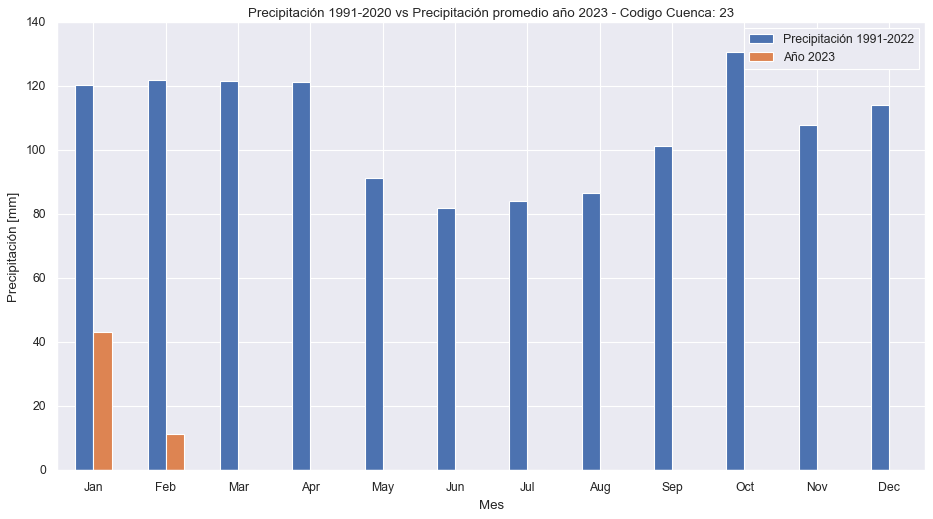

In [48]:
ax3 = PRECIP_ACTUAL_CUENCA.plot(x="Month", y=["CLIM_MEAN","ACTUAL"], kind="bar", rot=0,figsize=(14,7))
ax3.set_xlabel('Mes');
ax3.set_ylabel('Precipitación [mm]');
ax3.set_title('Precipitación 1991-2020 vs Precipitación promedio año 2023 - Codigo Cuenca: {}'.format(codcuenca));
ax3.legend(['Precipitación 1991-2022','Año 2023']);

Se realiza un procedimiento de lluvia acumulada para ver como se viene comportando las precipitaciones en la cuenca seleccionada

In [49]:
PRECIP_ACTUAL_CUENCA['clim_cumsum'] = PRECIP_ACTUAL_CUENCA['CLIM_MEAN'].cumsum(axis=0);
PRECIP_ACTUAL_CUENCA['2023_cumsum'] = PRECIP_ACTUAL_CUENCA['ACTUAL'].cumsum(axis=0);

In [50]:
HTML(PRECIP_ACTUAL_CUENCA.head(12).to_html(index=False))

Month,CLIM_MEAN,ACTUAL,clim_cumsum,2023_cumsum
Jan,120.290000,43.1,120.290000,43.1
Feb,121.920000,11.4,242.210000,54.5
Mar,121.660000,NaN,363.870000,NaN
Apr,121.336667,NaN,485.206667,NaN
May,91.373333,NaN,576.580000,NaN
Jun,81.893333,NaN,658.473333,NaN
Jul,84.230000,NaN,742.703333,NaN
Aug,86.753333,NaN,829.456667,NaN
Sep,101.433333,NaN,930.890000,NaN
Oct,130.670000,NaN,1061.560000,NaN


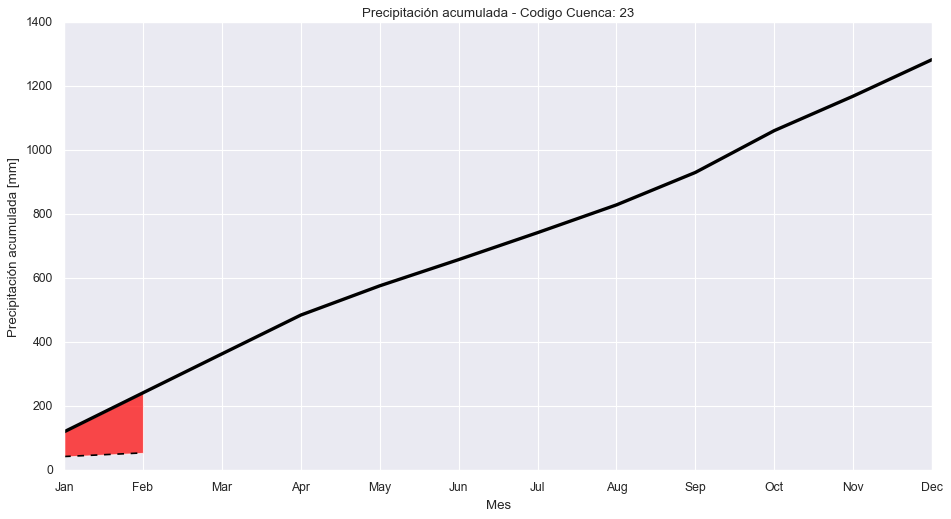

In [51]:
y1 = PRECIP_ACTUAL_CUENCA['clim_cumsum']
y2 = PRECIP_ACTUAL_CUENCA['2023_cumsum']

fig, (ax1) = plt.subplots(1, figsize=(14,7),sharex=True);
ax1.plot(PRECIP_ACTUAL_CUENCA['Month'], y1,color='black',linewidth=3);
ax1.plot(PRECIP_ACTUAL_CUENCA['Month'], y2,color='black',linestyle="--");
ax1.fill_between(PRECIP_ACTUAL_CUENCA['Month'],y1,y2, where=y1 >= y2, facecolor='red', interpolate=True,alpha=0.7)
ax1.fill_between(PRECIP_ACTUAL_CUENCA['Month'],y1,y2, where=y1 <= y2, facecolor='blue', interpolate=True,alpha=0.7)

ax1.set_xlabel('Mes');
ax1.set_ylabel('Precipitación acumulada [mm]');
ax1.set_title('Precipitación acumulada - Codigo Cuenca: {}'.format(codcuenca));